# 傾向スコア分析手法の比較（IPW, Matching, DoubleRobust）

このノートブックでは、傾向スコアを用いた因果推論の主要な3つの手法を同じデータセットで比較します：

1. **IPW (Inverse Probability Weighting)**: 傾向スコアの逆数で重み付けする手法
2. **Matching**: 傾向スコアが近いサンプル同士をマッチングする手法
3. **Double Robust**: IPWと回帰モデルを組み合わせた手法

これらの手法を用いて、TV CMの視聴によるゲーム利用傾向の変化を分析します。

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

%config InlineBackend.figure_format = 'retina'

In [2]:
%load_ext autoreload
%autoreload 2

from pycalf import metrics
from pycalf import visualize
from pycalf import propensity

## 1. データの読み込みと前処理

分析に使用するデータを読み込み、必要な変数を定義します。

In [3]:
# Download from https://raw.githubusercontent.com/iwanami-datascience/vol3/master/kato%26hoshino/q_data_x.csv
df = pd.read_csv("sample/q_data_x.csv")
df.head()

,cm_dummy,gamedummy,area_kanto,area_keihan,area_tokai,area_keihanshin,age,sex,marry_dummy,job_dummy1,...,T,F1,F2,F3,M1,M2,M3,TVwatch_day,gamesecond,gamecount
0,0,0,0,0,0,1,44.5,1,1,1,...,0,0,0,0,0,1,0,33.427600,0,0
1,0,0,0,1,0,0,34.5,1,1,1,...,0,0,0,0,0,1,0,31.542862,0,0
2,0,0,0,1,0,0,24.5,1,0,0,...,0,0,0,0,1,0,0,37.825805,0,0
3,0,0,0,1,0,0,44.5,1,1,1,...,0,0,0,0,0,1,0,36.345911,0,0
4,0,0,0,1,0,0,34.5,1,1,1,...,0,0,0,0,1,0,0,49.344942,0,0


In [4]:
# Define variables required for inference.
covariate_cols = [
    "TVwatch_day",
    "age",
    "sex",
    "marry_dummy",
    "child_dummy",
    "inc",
    "pmoney",
    "area_kanto",
    "area_tokai",
    "area_keihanshin",
    "job_dummy1",
    "job_dummy2",
    "job_dummy3",
    "job_dummy4",
    "job_dummy5",
    "job_dummy6",
    "job_dummy7",
    "fam_str_dummy1",
    "fam_str_dummy2",
    "fam_str_dummy3",
    "fam_str_dummy4",
]
outcome_cols = ["gamecount", "gamedummy", "gamesecond"]
treatment_col = "cm_dummy"

# Set Values from dataframe.
X = df[covariate_cols]
y = df[outcome_cols]
treatment = df[treatment_col].astype(bool)

# Scaling Raw Data.
scaler = preprocessing.MinMaxScaler()
scaled_X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

## 2. 傾向スコア分析手法の実装

3つの異なる傾向スコア手法を実装し、それぞれのモデルを訓練します。

In [5]:
# 共通のモデル設定
base_learner = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42)
pipeline_learner = Pipeline(
    [
        ("scaler", preprocessing.MinMaxScaler()),
        ("clf", LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42)),
    ]
)

In [6]:
# IPW (Inverse Probability Weighting)
ipw_model = propensity.IPW(base_learner)
ipw_model.fit(scaled_X, treatment.to_numpy())

# Matching
matching_model = propensity.Matching(pipeline_learner, min_match_dist=1e-2)
matching_model.fit(X, treatment.to_numpy(), y.to_numpy())

# Double Robust
dr_model = propensity.DoubleRobust(base_learner, pipeline_learner)
dr_model.fit(scaled_X, treatment.to_numpy(), y.to_numpy())

## 3. 各手法の評価と比較

以下では、各手法について評価し、結果を比較します。

### 3.1 効果量dの比較

効果量dを使って、各手法がどれだけ共変量のバランスを改善したかを評価します。

In [7]:
# 各モデルのATE重みを取得
ipw_weight = ipw_model.get_weight(treatment.to_numpy(), mode="ate")
matching_weight = matching_model.get_weight(treatment.to_numpy(), mode="ate")
dr_weight = dr_model.get_weight(treatment.to_numpy(), mode="ate")

# 重み無しの場合のEffect Size（調整前）
es_raw = metrics.EffectSize()
es_raw.fit(X, treatment.to_numpy())
effect_size_raw = es_raw.transform()

# 各手法でのEffect Size
es_ipw = metrics.EffectSize()
es_ipw.fit(X, treatment.to_numpy(), weight=ipw_weight)
effect_size_ipw = es_ipw.transform()

es_matching = metrics.EffectSize()
es_matching.fit(X, treatment.to_numpy(), weight=matching_weight)
effect_size_matching = es_matching.transform()

es_dr = metrics.EffectSize()
es_dr.fit(X, treatment.to_numpy(), weight=dr_weight)
effect_size_dr = es_dr.transform()

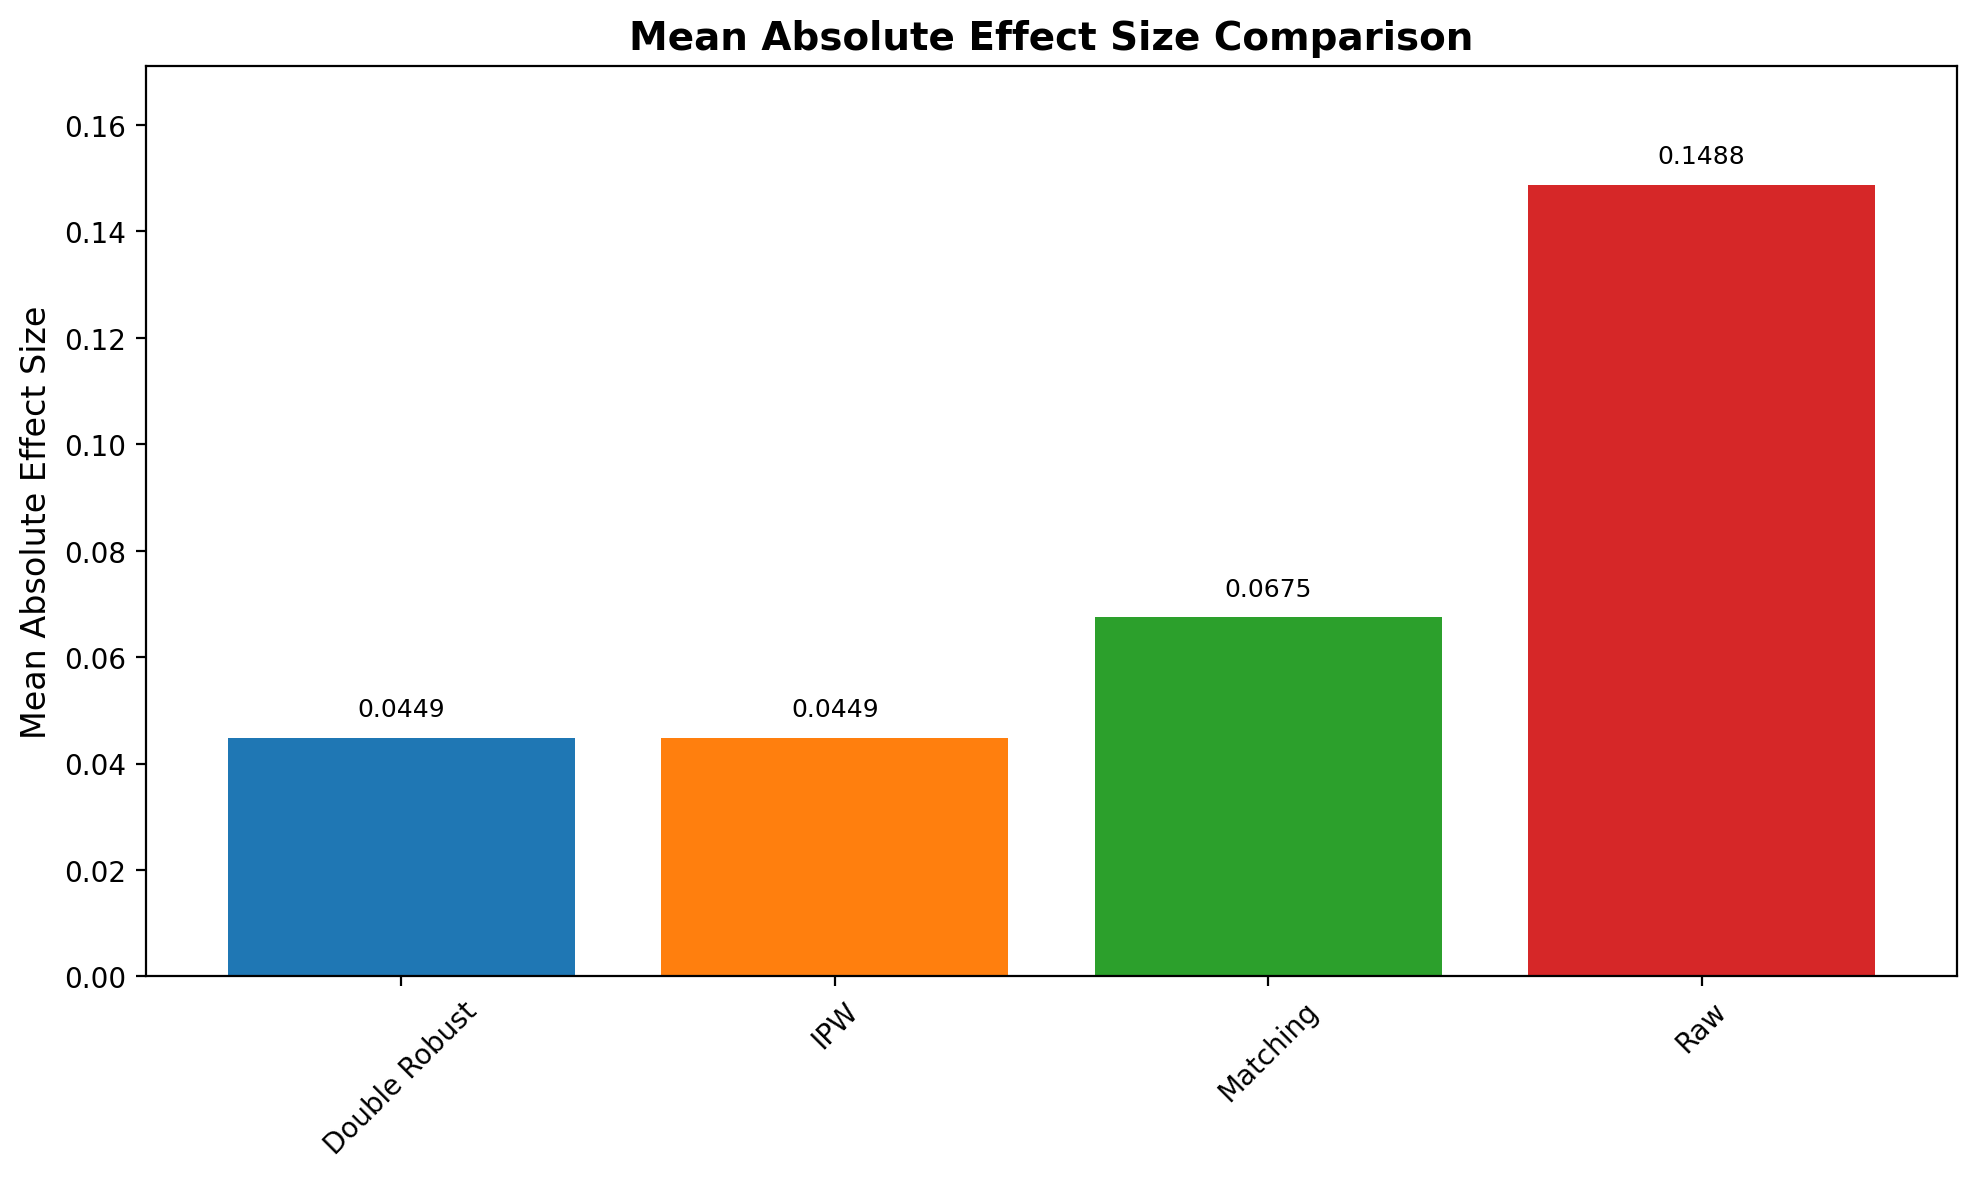

In [8]:
# 効果量dの結果比較
comparison_df = pd.DataFrame(
    {
        "Raw": effect_size_raw["effect_size"],
        "Matching": effect_size_matching["effect_size"],
        "IPW": effect_size_ipw["effect_size"],
        "Double Robust": effect_size_dr["effect_size"],
    }
)

# 平均絶対効果量を計算
mean_abs_effects = {
    "Raw": np.abs(effect_size_raw["effect_size"]).mean(),
    "Matching": np.abs(effect_size_matching["effect_size"]).mean(),
    "IPW": np.abs(effect_size_ipw["effect_size"]).mean(),
    "Double Robust": np.abs(effect_size_dr["effect_size"]).mean(),
}

# 効果量dの可視化
plt.figure(figsize=(10, 6))
# 可視化方法を更新：新しいAPIを使用
sorted_methods = sorted(mean_abs_effects.keys())
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

bars = plt.bar(
    sorted_methods,
    [mean_abs_effects[method] for method in sorted_methods],
    color=colors,
)

# 棒グラフの上に数値を表示
for i, bar in enumerate(bars):
    height = bar.get_height()
    method = sorted_methods[i]
    value = mean_abs_effects[method]
    plt.text(
        bar.get_x() + bar.get_width() / 2.0,
        height + 0.003,
        f"{value:.4f}",
        ha="center",
        va="bottom",
        fontsize=9,
    )

plt.ylabel("Mean Absolute Effect Size", fontsize=12)
plt.title("Mean Absolute Effect Size Comparison", fontsize=14, fontweight="bold")
plt.xticks(rotation=45)
plt.ylim(
    0, max(mean_abs_effects.values()) * 1.15
)  # グラフの上限を調整して数値を見やすく
plt.tight_layout()
plt.show()

### 3.2 AUCと傾向スコア分布の比較

各手法のAUCと傾向スコア分布を比較します。AUCは0.7以上が好ましいとされています。
参考：https://www.jstage.jst.go.jp/article/tenrikiyo/19/2/19_19-008/_pdf

F1スコア:
IPW: 0.6834
Matching: 0.6834
Double Robust: 0.6834


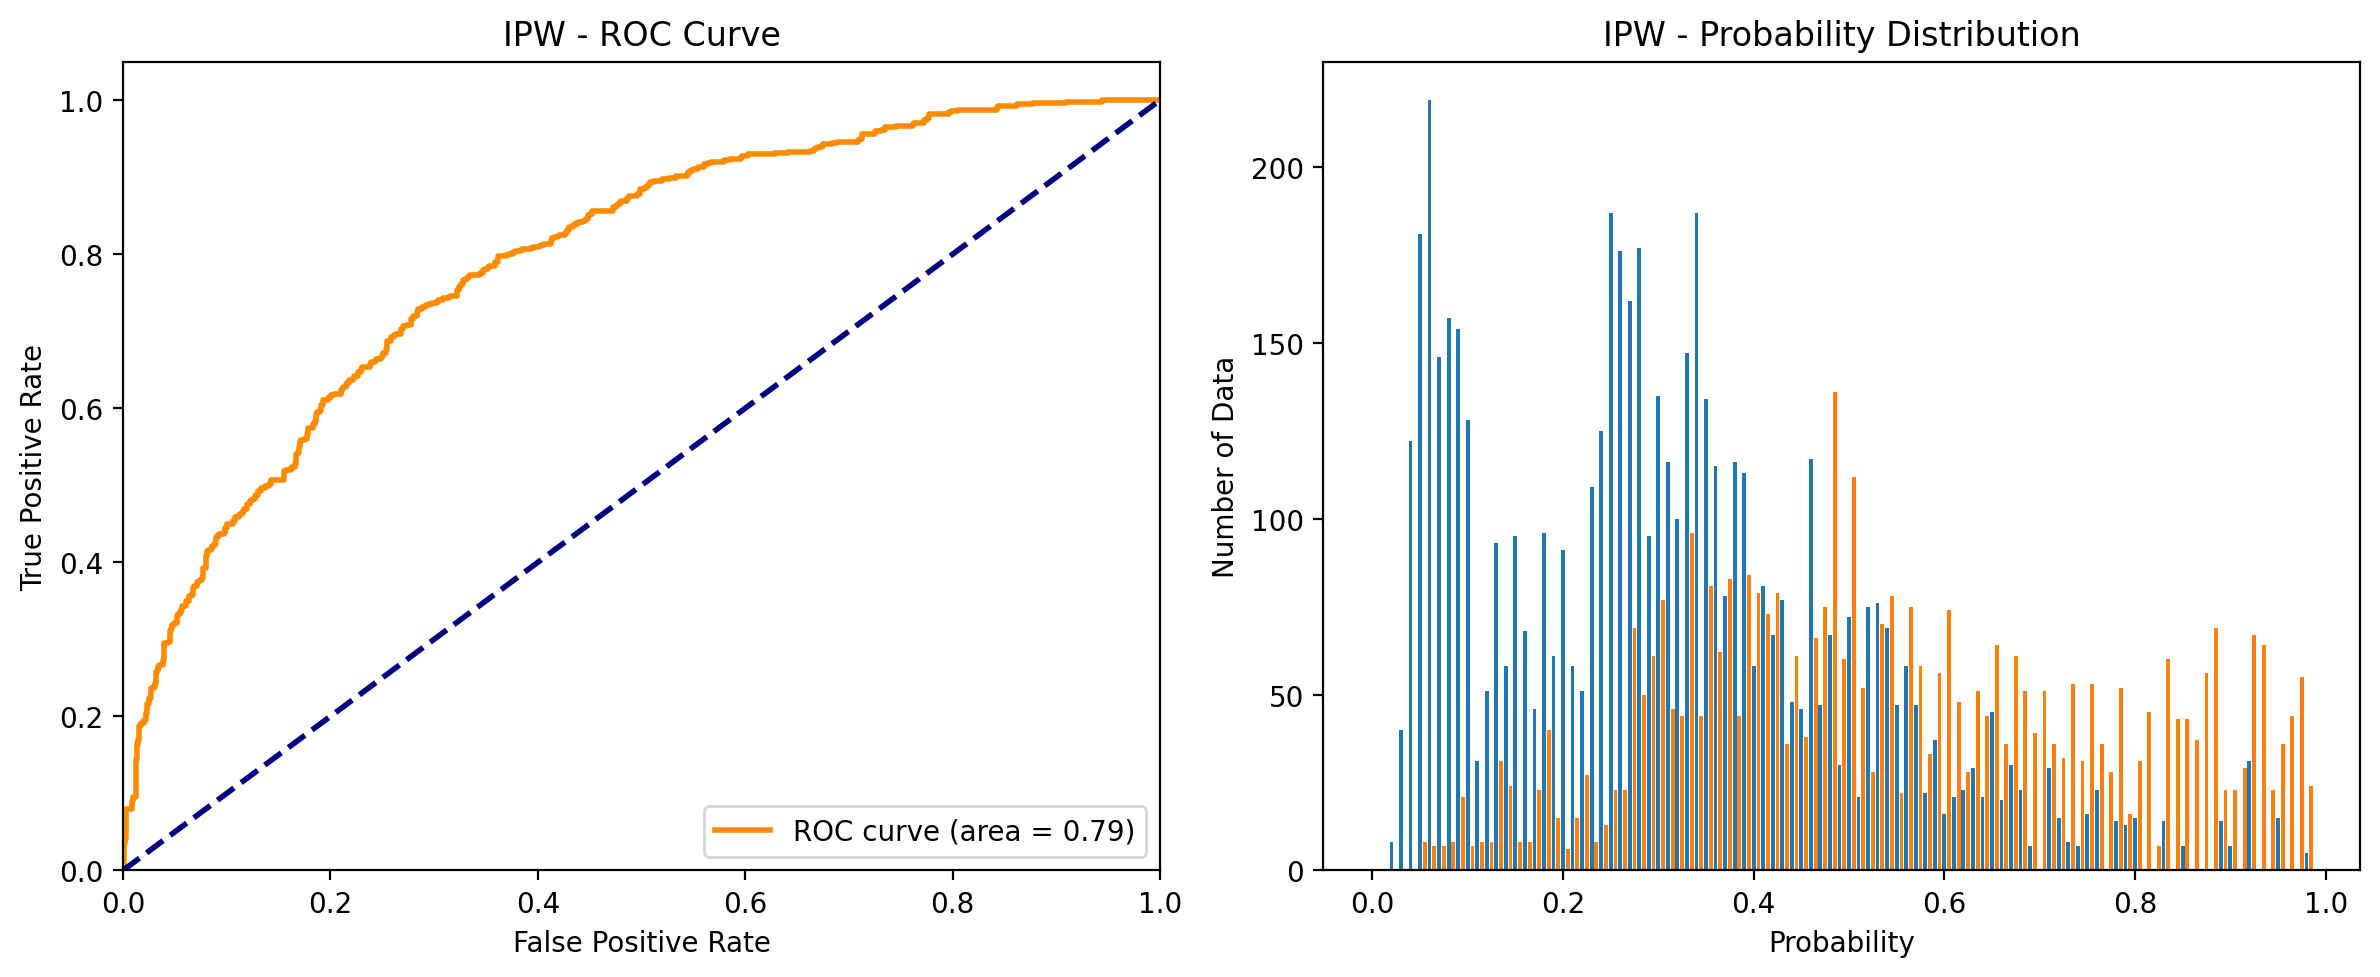

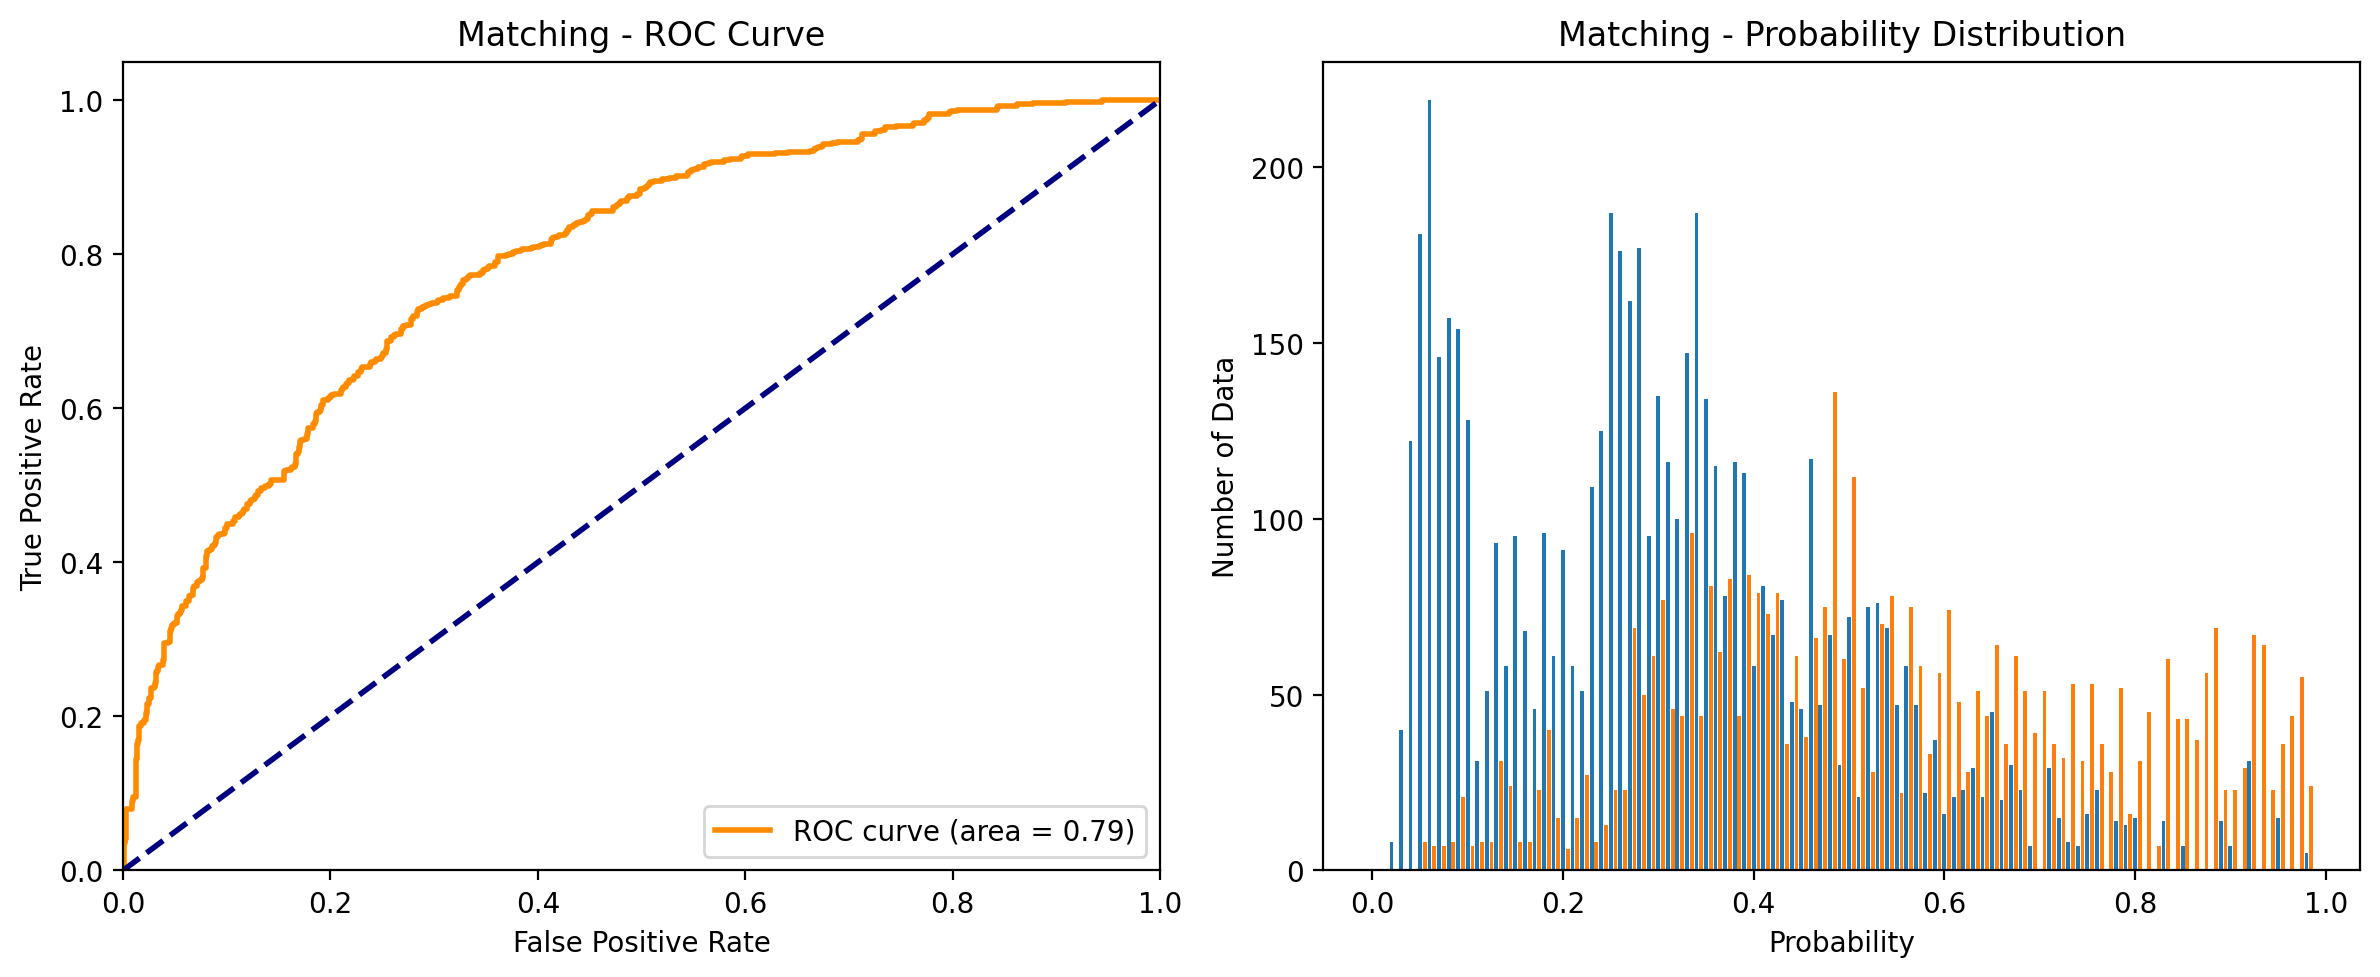

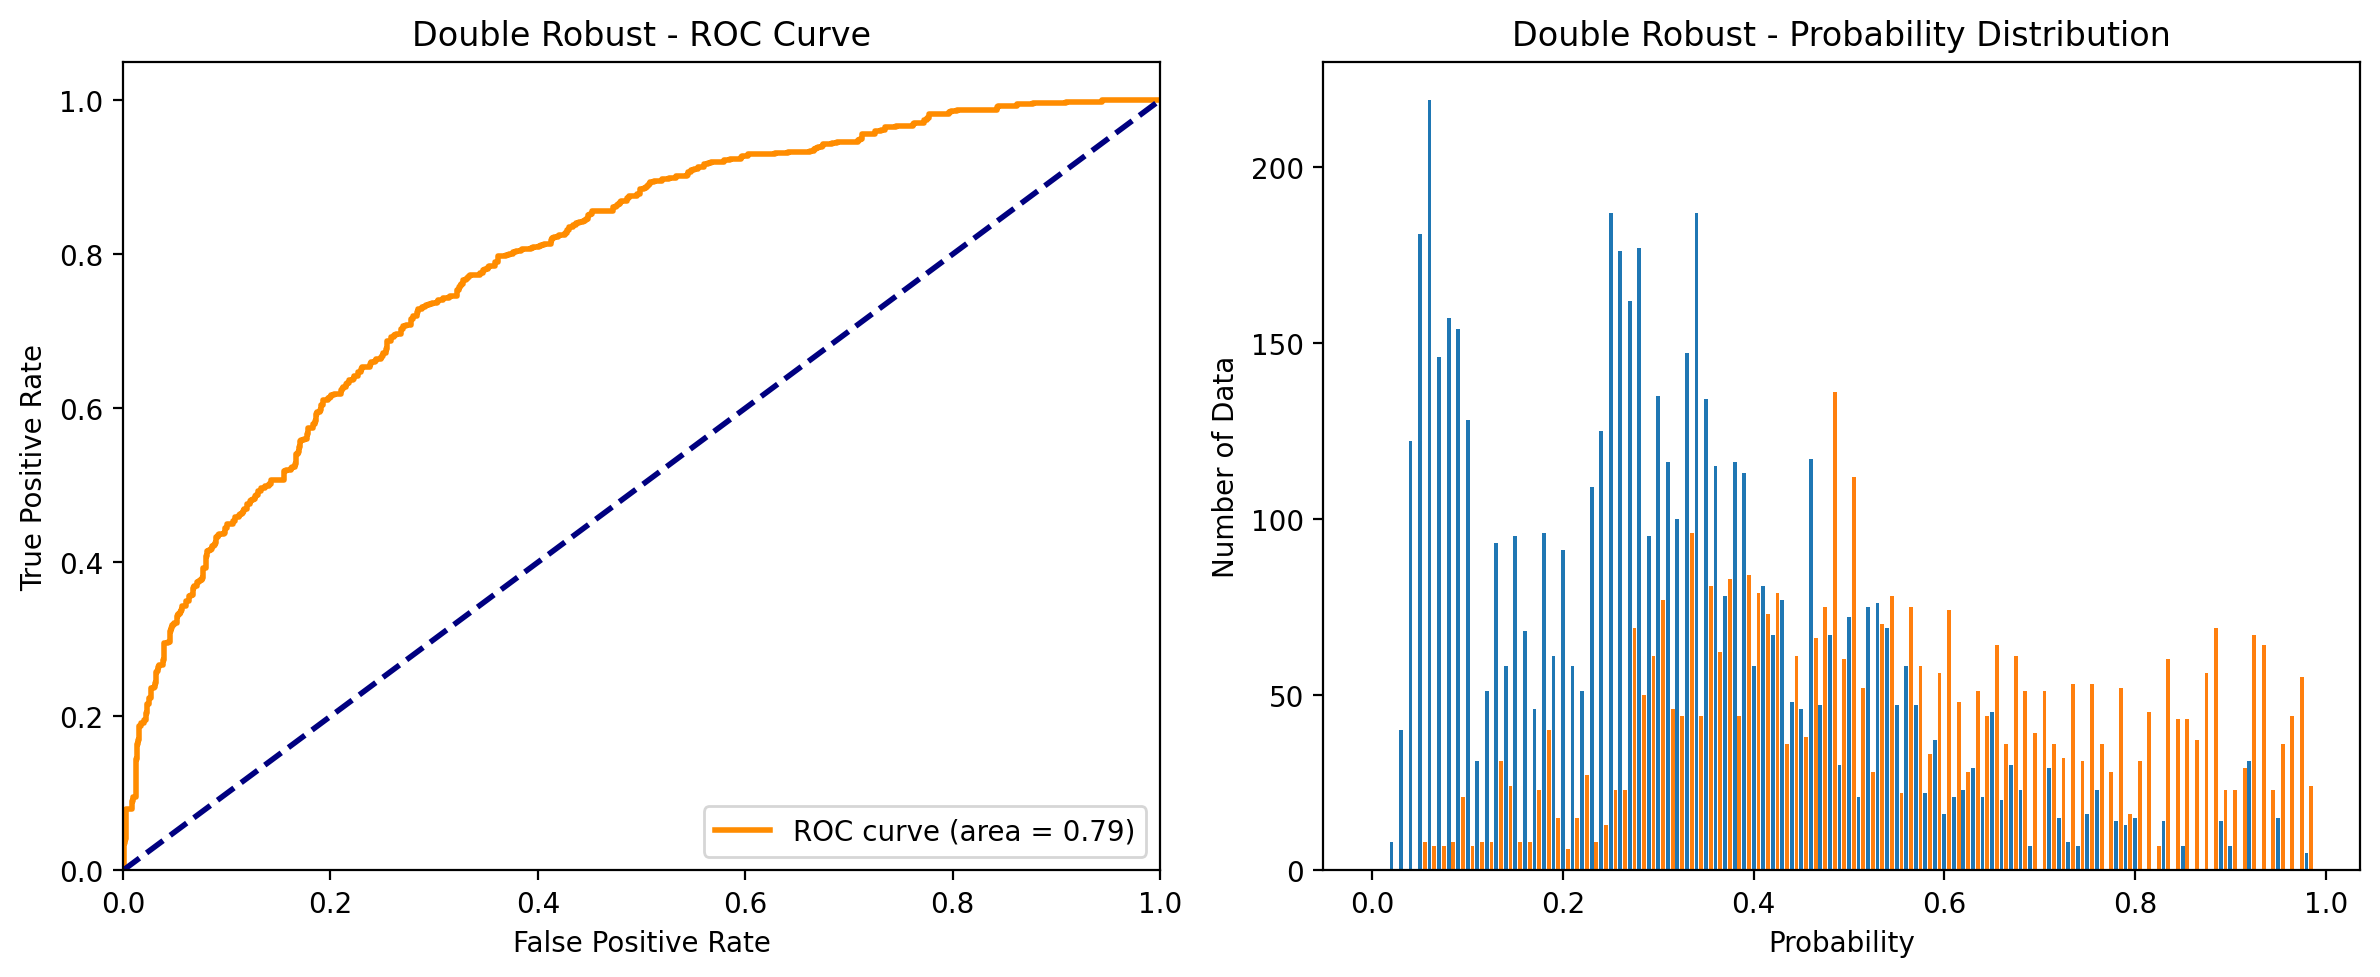

In [11]:
# 閾値の設定
threshold_value = 0.5
treatment_array = treatment.to_numpy()

# 各モデルのF1スコア
f1_scores = {
    "IPW": metrics.f1_score(
        treatment_array, ipw_model.get_score(), threshold=threshold_value
    ),
    "Matching": metrics.f1_score(
        treatment_array, matching_model.get_score(), threshold=threshold_value
    ),
    "Double Robust": metrics.f1_score(
        treatment_array, dr_model.get_score(), threshold=threshold_value
    ),
}

print("F1スコア:")
for method, score in f1_scores.items():
    print(f"{method}: {score:.4f}")

# IPWのROC曲線と確率分布を横に表示
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
visualize.plot_roc_curve(treatment_array, ipw_model.get_score(), ax=axes[0])
axes[0].set_title("IPW - ROC Curve")
visualize.plot_probability_distribution(
    treatment_array, ipw_model.get_score(), ax=axes[1]
)
axes[1].set_title("IPW - Probability Distribution")
plt.tight_layout()
plt.show()

# Matchingのロジック曲線と確率分布を横に表示
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
visualize.plot_roc_curve(treatment_array, matching_model.get_score(), ax=axes[0])
axes[0].set_title("Matching - ROC Curve")
visualize.plot_probability_distribution(
    treatment_array, matching_model.get_score(), ax=axes[1]
)
axes[1].set_title("Matching - Probability Distribution")
plt.tight_layout()
plt.show()

# Double RobustのROC曲線と確率分布を横に表示
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
visualize.plot_roc_curve(treatment_array, dr_model.get_score(), ax=axes[0])
axes[0].set_title("Double Robust - ROC Curve")
visualize.plot_probability_distribution(
    treatment_array, dr_model.get_score(), ax=axes[1]
)
axes[1].set_title("Double Robust - Probability Distribution")
plt.tight_layout()
plt.show()

### 3.3 平均処置効果（ATE）の比較

各手法による平均処置効果（ATE: Average Treatment Effect）を比較します。

In [12]:
# 各手法のATE推定
ipw_outcome = ipw_model.estimate_effect(treatment_array, y.to_numpy(), mode="ate")
matching_outcome = matching_model.estimate_effect(
    treatment_array, y.to_numpy(), mode="ate"
)
dr_outcome = dr_model.estimate_effect(treatment_array, mode="ate")

# IPWの結果をデータフレームに
ipw_df = pd.DataFrame(
    ipw_outcome, index=["Z0", "Z1", "ATE"], columns=y.columns.tolist()
)

# Matchingの結果をデータフレームに
matching_df = pd.DataFrame(
    matching_outcome, index=["Z0", "Z1", "ATE"], columns=y.columns.tolist()
)

# Double Robustの結果をデータフレームに
# Double Robustの出力形式が異なるため調整
dr_df = pd.DataFrame(
    {
        "gamecount": dr_outcome[0],
        "gamedummy": dr_outcome[1],
        "gamesecond": dr_outcome[2],
    },
    index=["Z0", "Z1", "ATE"],
)

# 結果の表示
print("IPW - 平均処置効果:")
display(ipw_df.T)

print("\nMatching - 平均処置効果:")
display(matching_df.T)

print("\nDouble Robust - 平均処置効果:")
display(dr_df.T)

IPW - 平均処置効果:


,Z0,Z1,ATE
gamecount,8.482789,13.041085,4.558296
gamedummy,0.063531,0.092869,0.029338
gamesecond,2690.247748,3929.405661,1239.157912



Matching - 平均処置効果:


,Z0,Z1,ATE
gamecount,6.784687,8.563948,1.779261
gamedummy,0.073484,0.075290,0.001806
gamesecond,2836.363309,2478.065878,-358.297431



Double Robust - 平均処置効果:


,Z0,Z1,ATE
gamecount,4.445034,0.033291,1409.706628
gamedummy,6.207475,0.045828,1870.372544
gamesecond,1.762440,0.012537,460.665916


In [13]:
# 結果の比較
ate_comparison = pd.DataFrame(
    {
        "IPW": ipw_df.loc["ATE"],
        "Matching": matching_df.loc["ATE"],
        "Double Robust": dr_df.loc["ATE"],
    }
).T

print("\n各手法のATE比較:")
display(ate_comparison)


各手法のATE比較:


,gamecount,gamedummy,gamesecond
IPW,4.558296,0.029338,1239.157912
Matching,1.779261,0.001806,-358.297431
Double Robust,1409.706628,1870.372544,460.665916


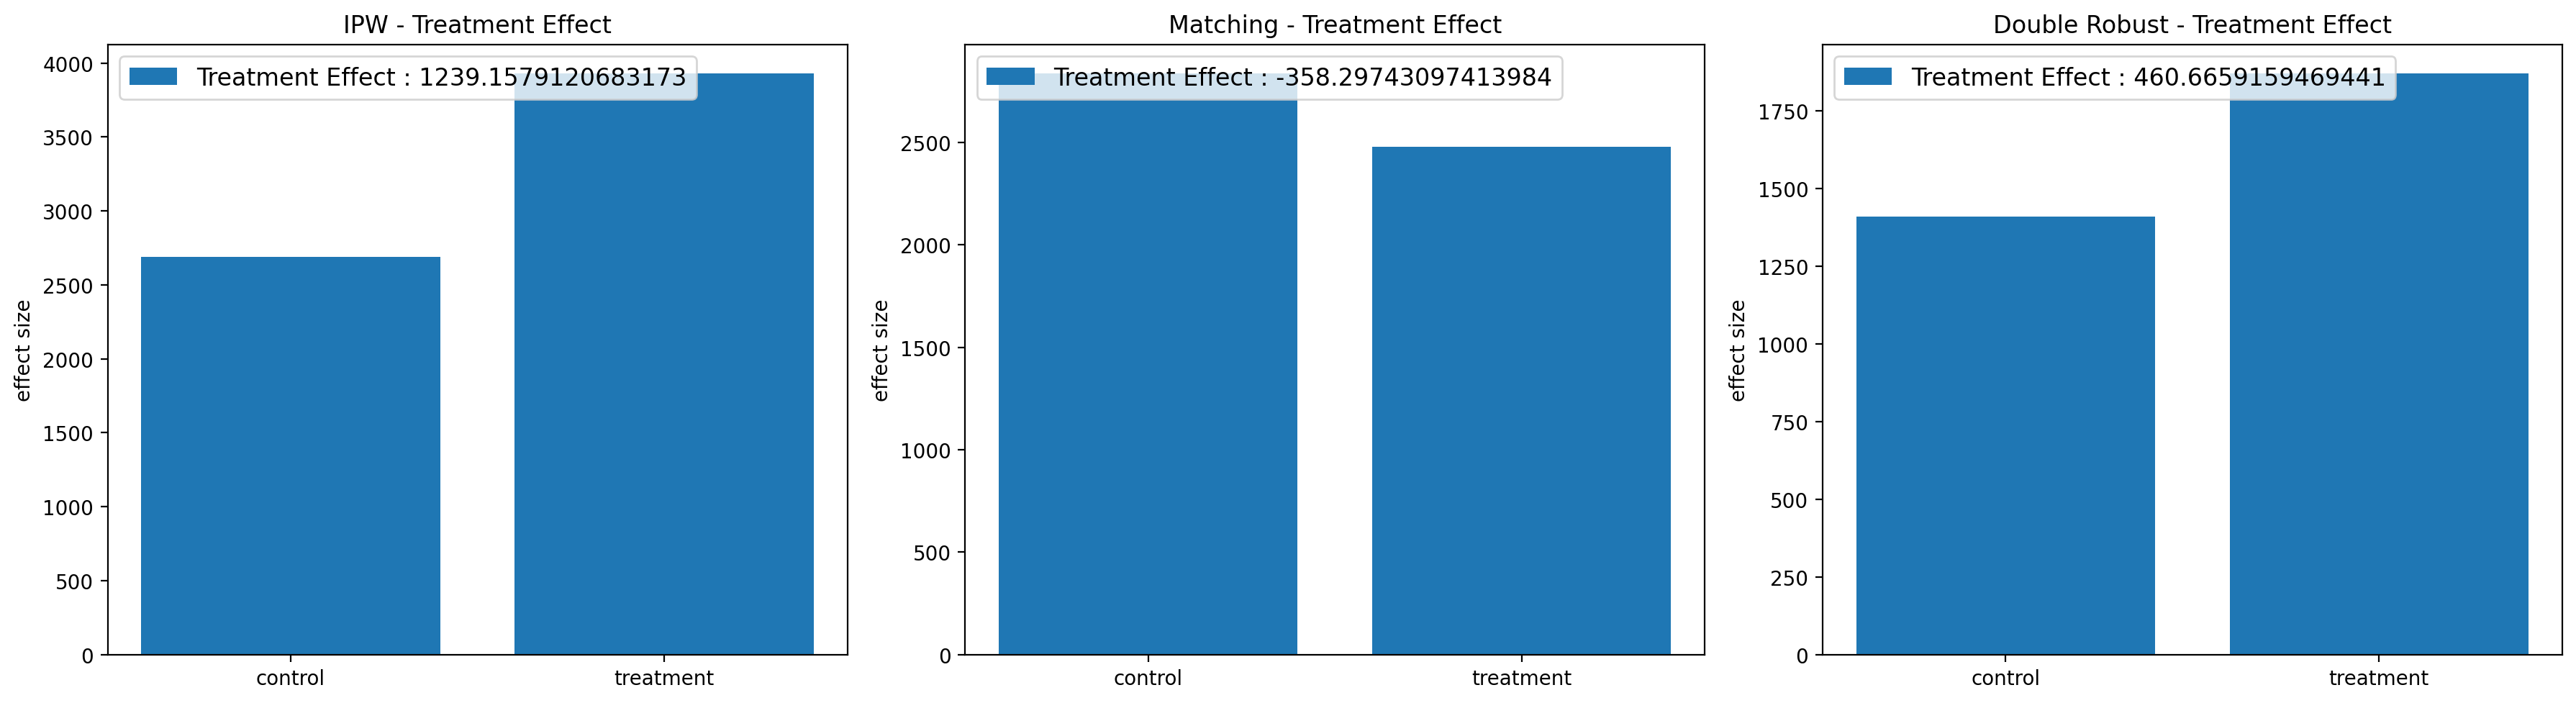

In [19]:
# gamesecondに対する処置効果の可視化比較
outcome_name = "gamesecond"

# サブプロットで3つの手法を可視化
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# IPW
z0_ipw, z1_ipw, effect_ipw = ipw_model.estimate_effect(
    treatment_array, y[outcome_name].to_numpy(), mode="ate"
)
visualize.plot_treatment_effect(outcome_name, z0_ipw, z1_ipw, effect_ipw, ax=axes[0])
axes[0].set_title("IPW - Treatment Effect")

# Matching - 更新されたAPIを使用
z0_matching, z1_matching, effect_matching = matching_model.estimate_effect(
    treatment_array, y[outcome_name].to_numpy().reshape(-1, 1), mode="ate"
)
visualize.plot_treatment_effect(
    outcome_name, z0_matching[0], z1_matching[0], effect_matching[0], ax=axes[1]
)
axes[1].set_title("Matching - Treatment Effect")

# Double Robust
z0_dr, z1_dr, effect_dr = dr_outcome[0][2], dr_outcome[1][2], dr_outcome[2][2]

visualize.plot_treatment_effect(outcome_name, z0_dr, z1_dr, effect_dr, ax=axes[2])
axes[2].set_title("Double Robust - Treatment Effect")

plt.tight_layout()
plt.show()

### 3.4 属性変数を用いた介入効果の比較

各属性変数ごとの介入効果を各手法で比較します。

In [20]:
# 属性変数と結果変数の定義
features = [
    "child_dummy",
    "area_kanto",
    "area_keihan",
    "area_tokai",
    "area_keihanshin",
    "T",
    "F1",
    "F2",
    "F3",
    "M1",
    "M2",
    "M3",
]
outcome_var = "gamesecond"

# 各手法での属性効果の計算
# IPW
attr_effect_ipw = metrics.AttributeEffect()
attr_effect_ipw.fit(df[features], df[treatment_col], df[outcome_var], weight=ipw_weight)
result_ipw = attr_effect_ipw.transform()

# Matching
attr_effect_matching = metrics.AttributeEffect()
attr_effect_matching.fit(
    df[features], df[treatment_col], df[outcome_var], weight=matching_weight
)
result_matching = attr_effect_matching.transform()

# Double Robust
attr_effect_dr = metrics.AttributeEffect()
attr_effect_dr.fit(df[features], df[treatment_col], df[outcome_var], weight=dr_weight)
result_dr = attr_effect_dr.transform()

In [21]:
# 各手法の結果を表示
print("IPW - 属性効果:")
display(result_ipw)

print("\nMatching - 属性効果:")
display(result_matching)

print("\nDouble Robust - 属性効果:")
display(result_dr)

IPW - 属性効果:


,Z0_effect,Z0_tvalue,Z1_effect,Z1_tvalue,Lift
M1,5816.4,9.12**,191.0,0.24,-5625.4
child_dummy,1804.0,3.5**,-1678.1,-2.59**,-3482.1
area_tokai,2113.7,3.61**,-1318.9,-1.52,-3432.6
area_kanto,1966.9,2.59**,-944.4,-1.02,-2911.3
F1,-972.9,-1.5,-2170.0,-2.41**,-1197.1
T,5811.8,2.77**,4975.8,2.01**,-836.0
area_keihan,1998.9,5.22**,1770.3,3.62**,-228.6
M3,-1345.4,-2.36**,-1217.8,-1.63,127.6
F2,-351.0,-0.53,-128.6,-0.17,222.4
F3,-1644.9,-1.94,-1271.1,-1.04,373.8



Matching - 属性効果:


,Z0_effect,Z0_tvalue,Z1_effect,Z1_tvalue,Lift
M1,6889.1,11.03**,906.9,1.25,-5982.2
area_kanto,3038.7,5.51**,-102.3,-0.16,-3141.0
F1,1468.0,2.49**,-1430.4,-2.05**,-2898.4
F2,2818.5,4.86**,124.0,0.22,-2694.5
child_dummy,1373.4,3.11**,-274.2,-0.53,-1647.6
area_tokai,-36.5,-0.06,-920.5,-1.21,-884.0
area_keihan,2186.8,5.56**,2259.8,5.92**,73.0
M3,-2343.8,-4.57**,-1071.9,-1.84,1271.9
F3,-1578.6,-1.91,551.8,0.57,2130.4
T,-1008.3,-0.37,2143.3,1.1,3151.6



Double Robust - 属性効果:


,Z0_effect,Z0_tvalue,Z1_effect,Z1_tvalue,Lift
M1,5816.4,9.12**,191.0,0.24,-5625.4
child_dummy,1804.0,3.5**,-1678.1,-2.59**,-3482.1
area_tokai,2113.7,3.61**,-1318.9,-1.52,-3432.6
area_kanto,1966.9,2.59**,-944.4,-1.02,-2911.3
F1,-972.9,-1.5,-2170.0,-2.41**,-1197.1
T,5811.8,2.77**,4975.8,2.01**,-836.0
area_keihan,1998.9,5.22**,1770.3,3.62**,-228.6
M3,-1345.4,-2.36**,-1217.8,-1.63,127.6
F2,-351.0,-0.53,-128.6,-0.17,222.4
F3,-1644.9,-1.94,-1271.1,-1.04,373.8


/home/konumaru/Documents/repository/pycalf/pycalf/visualize.py:338: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)
/home/konumaru/Documents/repository/pycalf/pycalf/visualize.py:338: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)
/home/konumaru/Documents/repository/pycalf/pycalf/visualize.py:338: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)


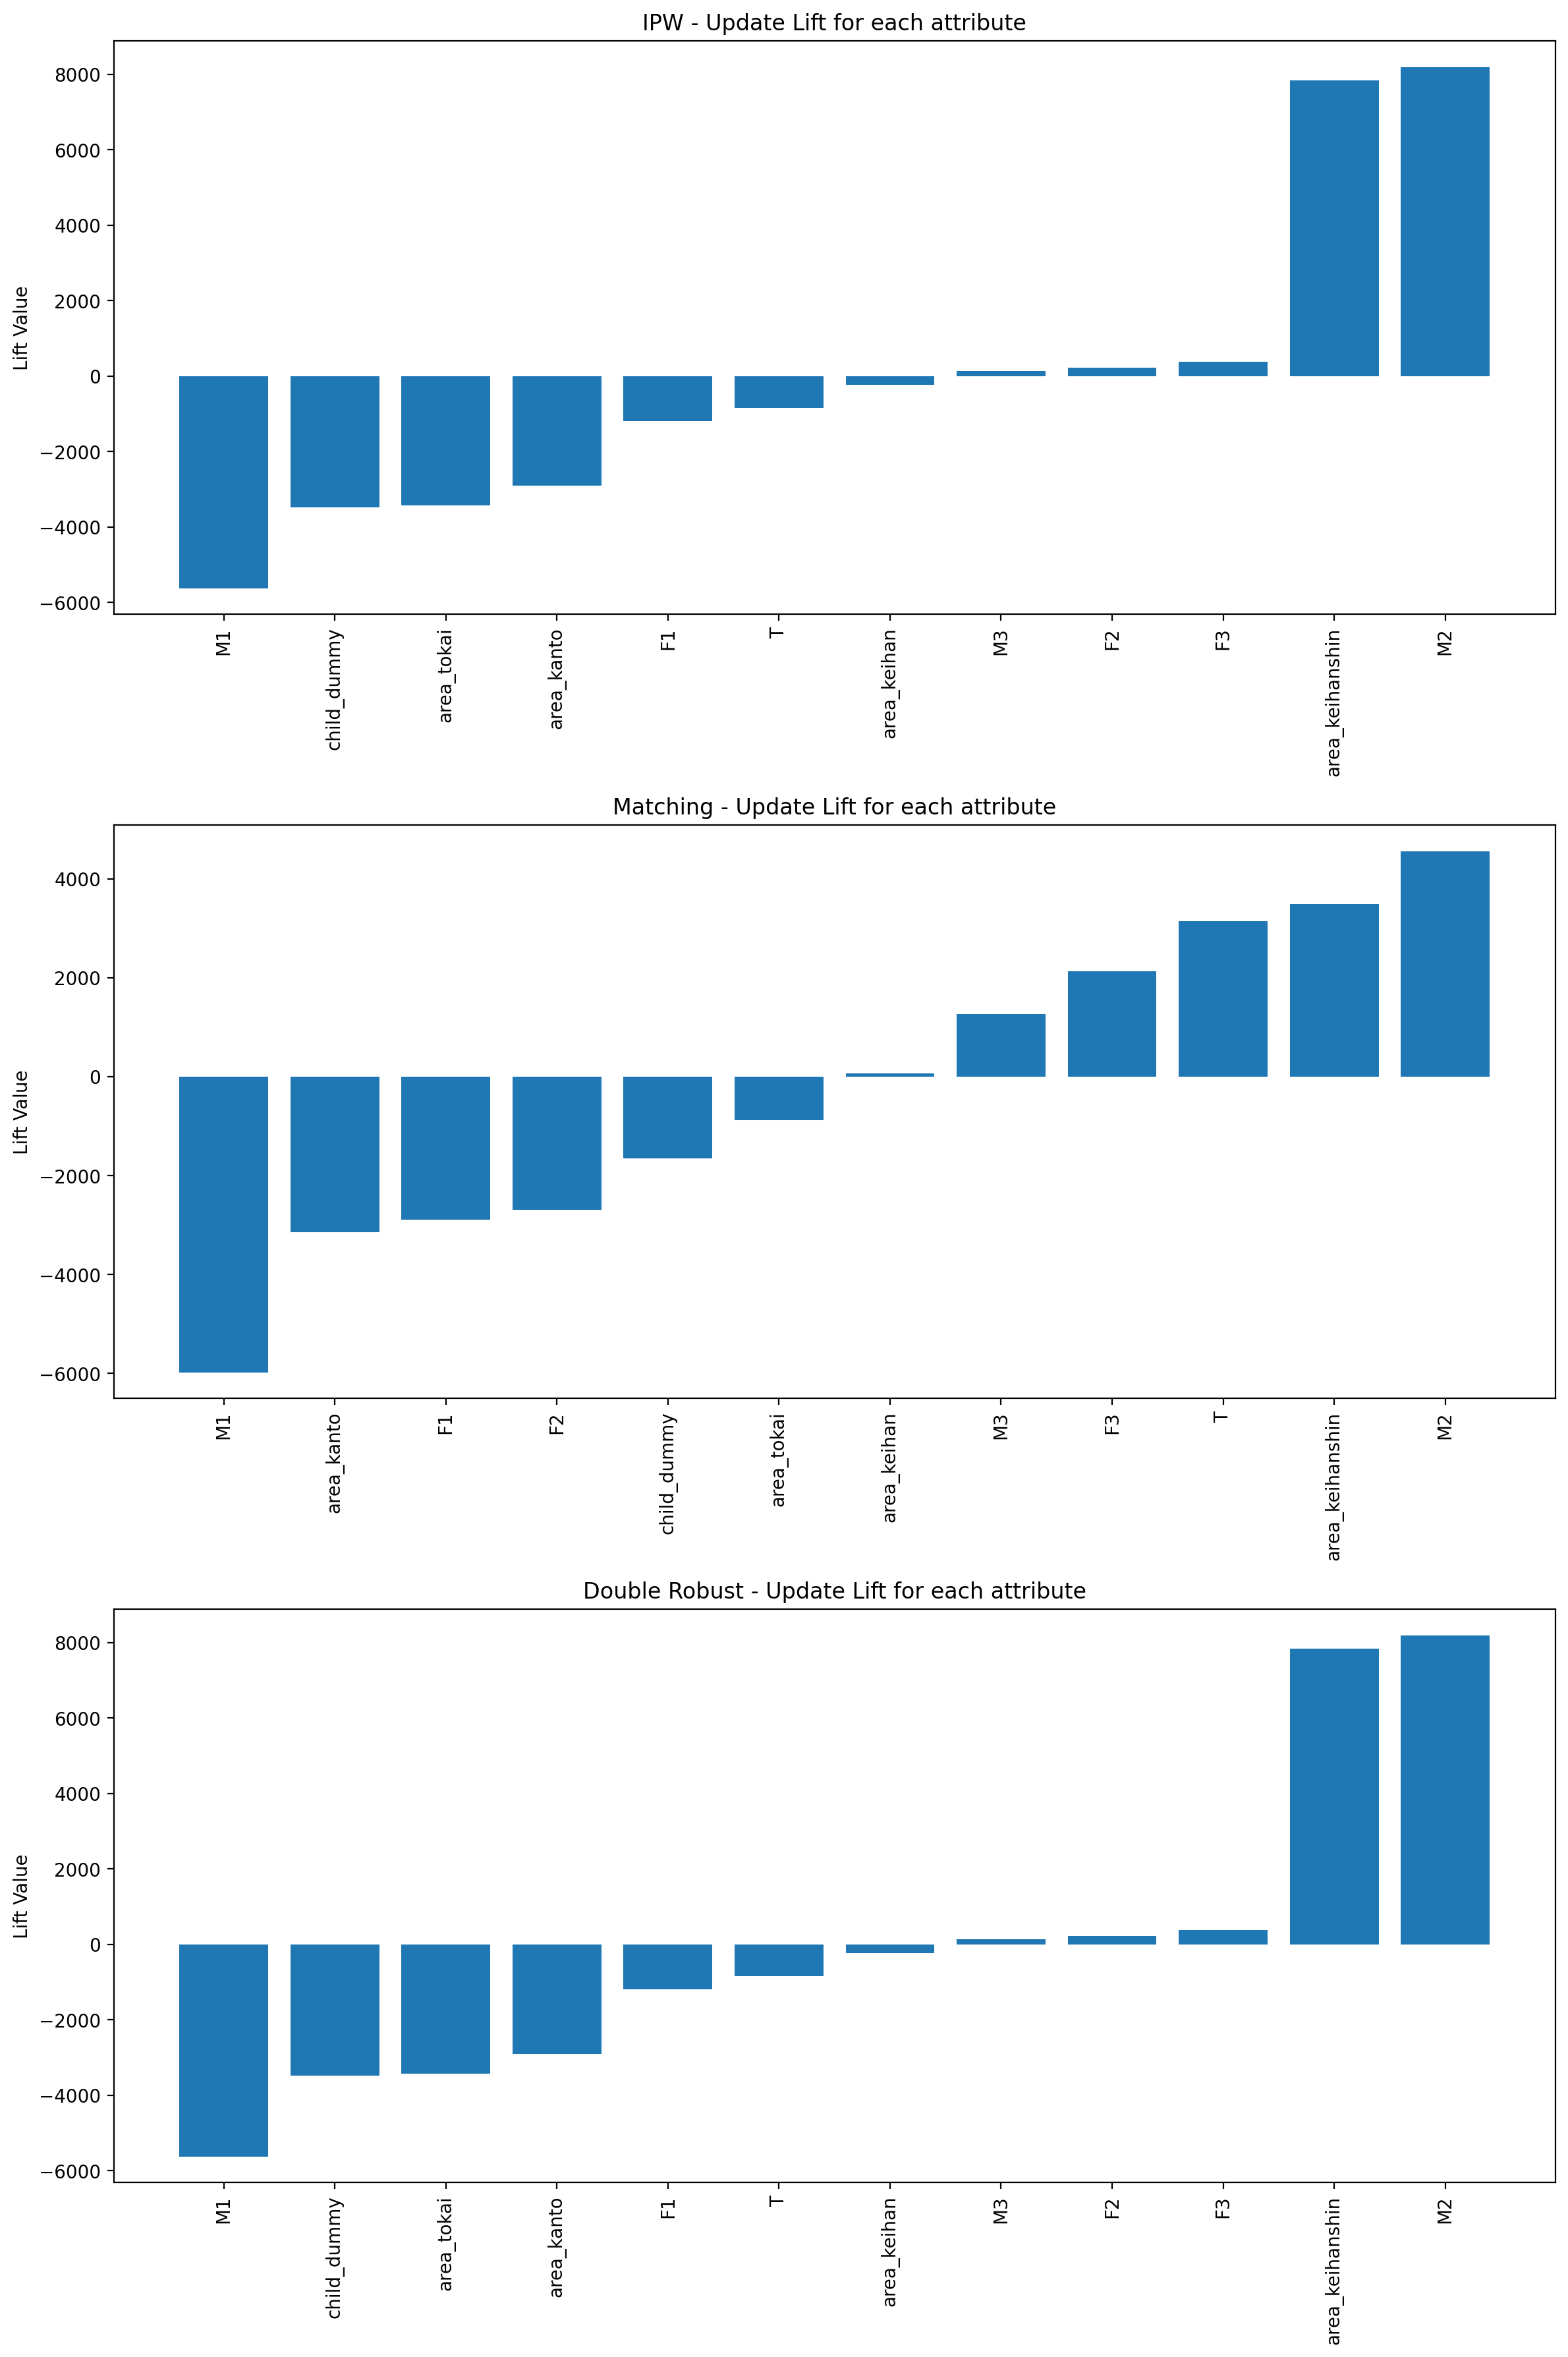

In [30]:
# 属性効果の可視化比較
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

visualize.plot_lift_values(
    labels=result_ipw.index.tolist(), values=result_ipw["Lift"].tolist(), ax=axes[0]
)
axes[0].set_title("IPW - Update Lift for each attribute")

# Matchingの結果を可視化
visualize.plot_lift_values(
    labels=result_matching.index.tolist(),
    values=result_matching["Lift"].tolist(),
    ax=axes[1],
)
axes[1].set_title("Matching - Update Lift for each attribute")
# Double Robustの結果を可視化
visualize.plot_lift_values(
    labels=result_dr.index.tolist(), values=result_dr["Lift"].tolist(), ax=axes[2]
)
axes[2].set_title("Double Robust - Update Lift for each attribute")

plt.tight_layout()
plt.show()

## 4. 総合評価

3つの傾向スコア分析手法（IPW、Matching、Double Robust）の比較結果をまとめます。

### 4.1 各手法の強みと弱み

- **IPW (Inverse Probability Weighting)**
  - 強み: 実装が比較的簡単で、計算コストが低い
  - 弱み: 極端な重みが発生しやすく、分散が大きくなる場合がある

- **Matching**
  - 強み: 解釈が直感的で、共変量のバランスが良くなる
  - 弱み: マッチングによりサンプルサイズが減少する可能性がある

- **Double Robust**
  - 強み: 傾向スコアモデルと結果モデルの両方が正しく指定されていれば、最も効率的な推定量になる
  - 弱み: 実装が複雑で、2つのモデルが必要

### 4.2 実践的な選択指針

- サンプルサイズが小さい場合は Double Robust が良い選択肢
- 共変量の数が多い場合は IPW や Double Robust が有効
- 解釈のしやすさを重視する場合は Matching が適している
- 複数の手法を試して結果を比較することが理想的

### 4.3 結論

このノートブックでは、傾向スコアを用いた3つの主要な因果推論手法を比較しました。各手法には固有の特性があり、分析の目的や状況に応じて適切な手法を選択することが重要です。また、複数の手法を併用して結果の頑健性を確認することも推奨されます。